#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


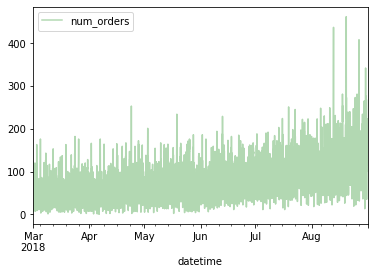

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.plot(color = 'green', alpha = 0.3)

**Вывод 1**
1. файл импортирован, в качестве индекса установлено время
2. сделано ресемплирование по одному часу, отмечается постепенное увеличение количества заказов

## Анализ

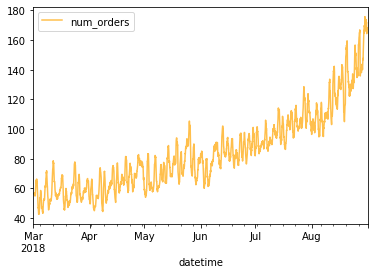

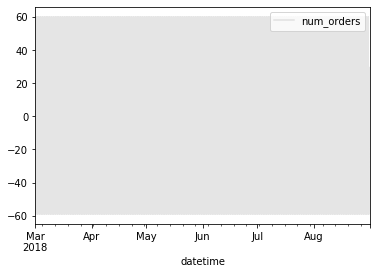

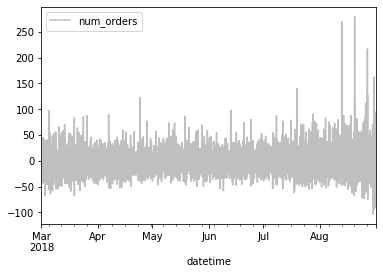

In [5]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(color = 'orange', alpha = 0.7)
decomposed.seasonal.plot(color = 'grey', alpha = 0.2)
decomposed.resid.plot(color = 'grey', alpha = 0.5)

In [6]:
def make_features(data, max_lag, rolling_mean_size):
#     data['year'] = data.index.year
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag, fill_value=0)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].fillna(0).astype('int')


make_features(data,2, 24)
data = data[data['rolling_mean'] != 0]

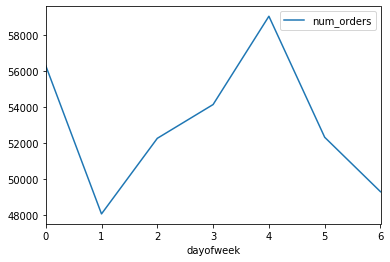

In [7]:
data.groupby('dayofweek').agg('sum').plot(y = 'num_orders')

In [8]:
#data.groupby('month').agg('sum').plot(y = 'num_orders')

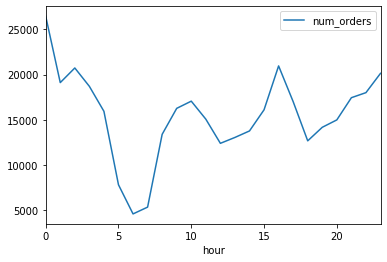

In [9]:
data.groupby('hour').agg('sum').plot(y = 'num_orders')

**Вывод 2**
1. тренд - восходящий
2. наименьшее количество заказов во вторник, наибольшее в пятницу
3. обычно наименьшее количество заказов в 5-6 утра, с 6 утра количество заказов начинает возрастать, достигая пика к 12 ночи, после чего начинается падение

## Обучение

In [10]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [11]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

print(train_features.shape, train_target.shape, test_features.shape, test_target.shape)

(3952, 5) (3952,) (440, 5) (440,)


In [12]:
train_features.head()

,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,4,0,58,113,56
2018-03-02 01:00:00,4,1,90,58,55
2018-03-02 02:00:00,4,2,120,90,56
2018-03-02 03:00:00,4,3,75,120,57
2018-03-02 04:00:00,4,4,64,75,56


In [13]:
numeric_columns = ['RMSE']
numeric_columns2 = ['R2']
def color(data):
    return (
        data
        .style
        .highlight_max(color='yellowgreen', subset=numeric_columns2)
        .highlight_min(color='yellowgreen', subset=numeric_columns)
        .highlight_max(color='coral', subset=numeric_columns)
        .highlight_min(color='coral', subset=numeric_columns2)
    )

In [14]:
scores = []
def fit_predict_model(model, model_name, train_target,train_features):

    model = model
    
    start = time.time()
    model.fit(train_features, train_target)
    end = time.time()
    eval_time = end-start
    
    start_predict = time.time()
    pred = model.predict(train_features)
    end_predict = time.time()
    eval_time_predict = end_predict - start_predict
    
    full_time = end_predict - start
    
    scores.append(pd.Series({'Estimator' : model_name,
                             'Fit_time' : eval_time,
                             'Predict_time': eval_time_predict, 
                             'Full_time': full_time,                          
                             'R2': r2_score(train_target, pred).round(3),
                             'MSE':mean_squared_error(train_target, pred),                            
                             'RMSE':mean_squared_error(train_target, pred)**0.5}))
    
    

In [15]:
fit_predict_model(LinearRegression(), 'LinearRegression', train_target,train_features)
fit_predict_model(DecisionTreeRegressor(random_state = 12345), 'DecisionTreeRegressor', train_target,train_features)
fit_predict_model(RandomForestRegressor(random_state = 12345), 'RandomForestRegressorr', train_target,train_features)
fit_predict_model(LGBMRegressor(), 'LGBMRegressor', train_target,train_features)
fit_predict_model(CatBoostRegressor(), 'CatBoostRegressor', train_target,train_features)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0:	learn: 38.1511577	total: 50.4ms	remaining: 50.4s
1:	learn: 37.5971785	total: 52.6ms	remaining: 26.3s
2:	learn: 37.1236336	total: 54.4ms	remaining: 18.1s
3:	learn: 36.5902246	total: 56.2ms	remaining: 14s
4:	learn: 36.1243465	total: 66.1ms	remaining: 13.2s
5:	learn: 35.6415437	total: 73.9ms	remaining: 12.2s
6:	learn: 35.2079114	total: 75.9ms	remaining: 10.8s
7:	learn: 34.8117611	total: 77.6ms	remaining: 9.62s
8:	learn: 34.4061895	total: 79.3ms	remaining: 8.73s
9:	learn: 34.0388309	total: 81ms	remaining: 8.02s
10:	learn: 33.7167345	total: 82.8ms	remaining: 7.44s
11:	learn: 33.3273809	total: 84.5ms	remaining: 6.96s
12:	learn: 32.9848988	total: 172ms	remaining: 13.1s
13:	learn: 32.6430364	total: 174ms	remaining: 12.2s
14:	learn: 32.3111696	total: 176ms	remaining: 11.5s
15:	learn: 32.0027675	total: 177ms	remaining: 10.9s
16:	learn: 31.7252719	total: 187ms	remaining: 10.8s
17:	learn: 31.4682914	total: 260ms	remaining: 14.2s
18:	learn: 31.2390659	total: 276ms	remaining: 14.3s
19:	learn: 30.

In [16]:
results = pd.concat(scores, axis=1).T.set_index('Estimator').pipe(color)
results

,Fit_time,Predict_time,Full_time,R2,MSE,RMSE
Estimator,,,,,,
LinearRegression,0.00266123,0.00100064,0.00366259,0.363,954.019,30.8872
DecisionTreeRegressor,0.162497,0.00238085,0.164879,1,0,0
RandomForestRegressorr,0.140934,0.00971437,0.15065,0.932,101.751,10.0872
LGBMRegressor,5.96504,0.10566,6.0707,0.815,276.982,16.6428
CatBoostRegressor,21.7561,0.00439119,21.7605,0.8,299.35,17.3017


In [17]:
scores_grid = []
def fit_predict_model_grid(model, hyperparameters, model_name, train_target,train_features):
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(model, hyperparameters,  scoring='neg_mean_squared_error',
                        cv=tscv, verbose=1,n_jobs=-1)

    
    start = time.time()
    best_model = grid.fit(train_features, train_target)
    end = time.time()
    eval_time = end-start
    
    start_predict = time.time()
    pred = best_model.predict(train_features)
    end_predict = time.time()
    eval_time_predict = end_predict - start_predict
    
    full_time = end_predict - start
    
    scores_grid.append(pd.Series({'Estimator' : model_name,
                             'Fit_time' : eval_time,
                             'Predict_time': eval_time_predict, 
                             'Full_time': full_time,
                             'best_parameter': best_model.best_params_, 
                             'best_score': best_model.best_score_,  
                             'R2': r2_score(train_target, pred).round(3),
                             'MSE':mean_squared_error(train_target, pred),                            
                             'RMSE':mean_squared_error(train_target, pred)**0.5}))
    return best_model.best_params_
    

In [18]:
param_lgmm = fit_predict_model_grid(
    LGBMRegressor(), 
    {'n_estimators': [ 400, 700],
     'max_depth': [None, 15,25]}, 
    'LGBMRegressor',
     train_target,train_features)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.8min finished


In [19]:
param_rf = fit_predict_model_grid(
    RandomForestRegressor(random_state = 12345), 
    {'n_estimators': range (1, 51, 5),
     'max_depth': [None, 1, 3, 5, 10, 20], 
     'min_samples_leaf': [ 1, 3, 5]}, 
    'RandomForestRegressor', 
     train_target,train_features )

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.5min finished


In [20]:
param_dt = fit_predict_model_grid(
    DecisionTreeRegressor(random_state = 12345), 
    {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]} , 
    'DecisionTreeRegressor', 
     train_target,train_features)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished


In [21]:
param_cat = fit_predict_model_grid(
    CatBoostRegressor(), 
    {'depth': [None, 1, 10],
     'iterations':[250,100, 150]} , 
    'CatBoostRegressor', 
     train_target,train_features)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 29.1906890	total: 2.05ms	remaining: 511ms
1:	learn: 28.8093459	total: 2.86ms	remaining: 354ms
2:	learn: 28.4610360	total: 3.65ms	remaining: 300ms
3:	learn: 28.1231291	total: 4.47ms	remaining: 275ms
4:	learn: 27.7455812	total: 5.25ms	remaining: 257ms
5:	learn: 27.3744103	total: 6.04ms	remaining: 246ms
6:	learn: 27.0763976	total: 6.84ms	remaining: 237ms
7:	learn: 26.7937469	total: 7.7ms	remaining: 233ms
8:	learn: 26.4811749	total: 8.55ms	remaining: 229ms
9:	learn: 26.1568267	total: 9.36ms	remaining: 225ms
10:	learn: 25.8608616	total: 10.2ms	remaining: 221ms
11:	learn: 25.5547057	total: 11ms	remaining: 217ms
12:	learn: 25.2903862	total: 11.9ms	remaining: 216ms
13:	learn: 24.9990213	total: 12.6ms	remaining: 213ms
14:	learn: 24.7175211	total: 13.4ms	remaining: 210ms
15:	learn: 24.4719714	total: 14.2ms	remaining: 207ms
16:	learn: 24.2380537	total: 27.1ms	remaining: 371ms
17:	learn: 24.0677351	total: 38.8ms	remaining: 500ms

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.2min finished


0:	learn: 38.1511577	total: 1.96ms	remaining: 488ms
1:	learn: 37.5971785	total: 3.88ms	remaining: 481ms
2:	learn: 37.1236336	total: 6.03ms	remaining: 496ms
3:	learn: 36.5902246	total: 7.82ms	remaining: 481ms
4:	learn: 36.1243465	total: 9.56ms	remaining: 468ms
5:	learn: 35.6415437	total: 11.3ms	remaining: 458ms
6:	learn: 35.2079114	total: 90.1ms	remaining: 3.13s
7:	learn: 34.8117611	total: 93.8ms	remaining: 2.84s
8:	learn: 34.4061895	total: 95.5ms	remaining: 2.56s
9:	learn: 34.0388309	total: 97.3ms	remaining: 2.33s
10:	learn: 33.7167345	total: 99ms	remaining: 2.15s
11:	learn: 33.3273809	total: 106ms	remaining: 2.1s
12:	learn: 32.9848988	total: 188ms	remaining: 3.43s
13:	learn: 32.6430364	total: 190ms	remaining: 3.21s
14:	learn: 32.3111696	total: 192ms	remaining: 3.01s
15:	learn: 32.0027675	total: 194ms	remaining: 2.83s
16:	learn: 31.7252719	total: 195ms	remaining: 2.68s
17:	learn: 31.4682914	total: 292ms	remaining: 3.77s
18:	learn: 31.2390659	total: 294ms	remaining: 3.58s
19:	learn: 30.

**Вывод 3**
1. данные разделены на тестовую и тренировочную выборки без перемешивания
2. было выполнено обучение и предсказание без подбора гиперпараметров и с подбором гиперпараметров
3. использовались следующие модели: LGBMRegressor, RandomForestRegressor, DecisionTreeRegressor, CatBoostRegressor, LinearRegression
4. Наилучший показатель на тренировочной выборке показала модель LGBMRegressor с параметрами {'max_depth': None, 'n_estimators': 400}, RMSE = 11.2

In [22]:
results_grid = pd.concat(scores_grid, axis=1).T.set_index('Estimator').pipe(color)
results_grid

,Fit_time,Predict_time,Full_time,best_parameter,best_score,R2,MSE,RMSE
Estimator,,,,,,,,
LGBMRegressor,851.303,0.292325,851.595,"{'max_depth': None, 'n_estimators': 400}",-686.581,0.916,125.955,11.2229
RandomForestRegressor,90.0842,0.0211165,90.1053,"{'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 31}",-647.066,0.865,201.662,14.2008
DecisionTreeRegressor,0.758826,0.00111341,0.759939,{'max_depth': 7},-859.159,0.663,505.464,22.4825
CatBoostRegressor,196.221,0.00264454,196.224,"{'depth': None, 'iterations': 250}",-691.275,0.683,475.198,21.799


## Тестирование

In [23]:
scores_test = []
def test(model, model_name, train_features, train_target, test_features, test_target):
    model = model
    model.fit(train_features, train_target)
    pred_test = model.predict(test_features)
    scores_test.append(pd.Series({'Estimator' : model_name, 
                             'R2': r2_score(test_target, pred_test).round(3),
                             'MSE':mean_squared_error(test_target, pred_test),                            
                             'RMSE':mean_squared_error(test_target, pred_test)**0.5}))

In [24]:
test(DecisionTreeRegressor(random_state = 12345), 'DecisionTreeRegressor', train_features, train_target, test_features, test_target)
test(LinearRegression(), 'LinearRegression', train_features, train_target, test_features, test_target)                                                                  
test(RandomForestRegressor(random_state = 12345), 'RandomForestRegressorr', train_features, train_target, test_features, test_target)
test(LGBMRegressor(), 'LGBMRegressor',  train_features, train_target, test_features, test_target)
test(CatBoostRegressor(), 'CatBoostRegressor',  train_features, train_target, test_features, test_target)

test(DecisionTreeRegressor(**param_dt, random_state = 12345), 'DecisionTreeRegressor grid', train_features, train_target, test_features, test_target)                                                     
test(RandomForestRegressor(**param_rf, random_state = 12345), 'RandomForestRegressor grid', train_features, train_target, test_features, test_target)
test(LGBMRegressor(**param_lgmm), 'LGBMRegressor grid',  train_features, train_target, test_features, test_target)
test(CatBoostRegressor(**param_cat), 'CatBoostRegressor grid',  train_features, train_target, test_features, test_target)    

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0:	learn: 38.1511577	total: 2.04ms	remaining: 2.04s
1:	learn: 37.5971785	total: 4.14ms	remaining: 2.06s
2:	learn: 37.1236336	total: 5.86ms	remaining: 1.95s
3:	learn: 36.5902246	total: 7.67ms	remaining: 1.91s
4:	learn: 36.1243465	total: 9.41ms	remaining: 1.87s
5:	learn: 35.6415437	total: 16.4ms	remaining: 2.72s
6:	learn: 35.2079114	total: 71.3ms	remaining: 10.1s
7:	learn: 34.8117611	total: 76.6ms	remaining: 9.5s
8:	learn: 34.4061895	total: 78.4ms	remaining: 8.63s
9:	learn: 34.0388309	total: 80.3ms	remaining: 7.95s
10:	learn: 33.7167345	total: 82.1ms	remaining: 7.38s
11:	learn: 33.3273809	total: 89ms	remaining: 7.33s
12:	learn: 32.9848988	total: 168ms	remaining: 12.7s
13:	learn: 32.6430364	total: 179ms	remaining: 12.6s
14:	learn: 32.3111696	total: 180ms	remaining: 11.8s
15:	learn: 32.0027675	total: 187ms	remaining: 11.5s
16:	learn: 31.7252719	total: 272ms	remaining: 15.7s
17:	learn: 31.4682914	total: 274ms	remaining: 14.9s
18:	learn: 31.2390659	total: 276ms	remaining: 14.2s
19:	learn: 30

In [25]:
result_test = (
    pd
    .concat(scores_test, axis=1).T
    .set_index('Estimator')
    .pipe(color))
result_test

,R2,MSE,RMSE
Estimator,,,
DecisionTreeRegressor,0.055,3248.1,56.9921
LinearRegression,0.234,2631.92,51.3023
RandomForestRegressorr,0.317,2348.87,48.4652
LGBMRegressor,0.446,1906.01,43.6579
CatBoostRegressor,0.414,2013.57,44.8728
DecisionTreeRegressor grid,-0.022,3511.6,59.2587
RandomForestRegressor grid,0.377,2141.51,46.2764
LGBMRegressor grid,0.384,2117.97,46.0215
CatBoostRegressor grid,0.326,2317.2,48.1373


**Вывод 4**

На тестовой выборке были проверены все модели, наилучший результат показала модель LGBMRegressor без подбора параметров RMSE = 43.66


In [26]:
test_target = test_target.reset_index().num_orders

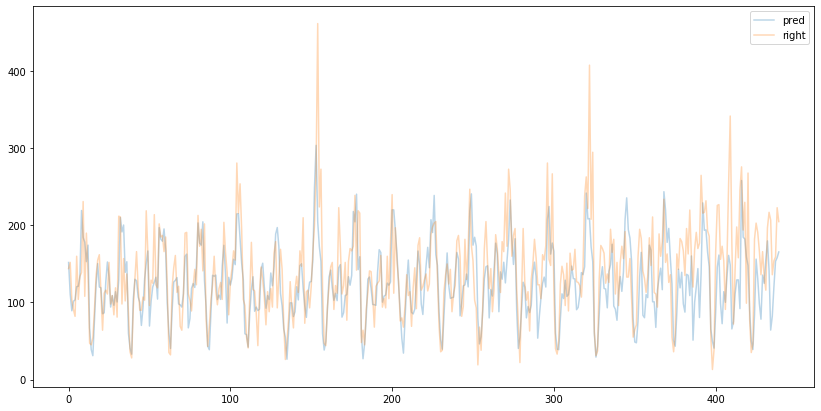

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
model = LGBMRegressor(**param_lgmm)
model.fit(train_features, train_target)
pred_test = model.predict(test_features)
plt.figure(figsize=(14,7))
sns.lineplot(data = pred_test, alpha = 0.3)
sns.lineplot(data = test_target, alpha = 0.3)
plt.legend(['pred', 'right'])

ВОПРОСЫ РЕВЬЮЕРУ

- Как красиво построить график по предсказанным значениям? 
- Почему по дереву решений получился 0 по RMSE при проверке на тренировочной выборке?
- По какому принципу надо подбирать количество дополнительных столбиков lag_?
- Как убрать выводимые строки при обучении при использовании CatBoostRegressor?

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48